## Temporal network using optical flow

    The idea is to now apply conv  net to optical flow similar  to zisserman paper. We want to stack optical flow images on top of each other effectively to represent the temporal stream of an activity. Before that want to first create an optical flow data generator for this purpose and first thing I'll check is to see if DataImage generator can be used with a custom image generator. 

In [1]:
from keras.preprocessing.image import ImageDataGenerator
import cv2
from matplotlib import pyplot as plt
import os
import sys

up1 = os.path.abspath('..') 
sys.path.insert(0, up1)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
# read in an image 

img = cv2.imread('/data/tvl1_flow/u/v_BaseballPitch_g01_c01/frame000010.jpg', 0)
img[:1]


array([[128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128,
        128, 128, 128, 129, 129, 129, 129, 129, 129, 129, 129, 128, 128,
        128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128,
        128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128,
        128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128,
        128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128,
        128, 128, 128, 128, 128, 128, 128, 128, 127, 127, 128, 128, 128,
        128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128,
        128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128,
        128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128,
        128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128,
        128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128,
        128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128,
        128, 128, 128, 128, 128, 128, 128, 128, 128

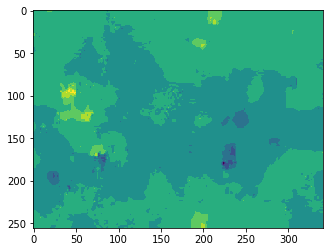

In [3]:
plt.imshow(img)

In [4]:
datagen = ImageDataGenerator(rescale=1./255)

In [5]:
img_t = datagen.random_transform(img)
img_t[:1]

array([[128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128,
        128, 128, 128, 129, 129, 129, 129, 129, 129, 129, 129, 128, 128,
        128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128,
        128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128,
        128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128,
        128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128,
        128, 128, 128, 128, 128, 128, 128, 128, 127, 127, 128, 128, 128,
        128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128,
        128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128,
        128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128,
        128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128,
        128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128,
        128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128,
        128, 128, 128, 128, 128, 128, 128, 128, 128

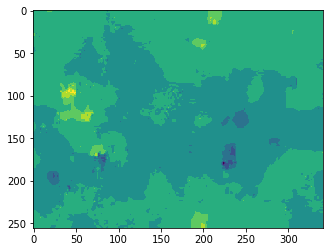

In [6]:
plt.imshow(img_t)

In [7]:
from network import getVggModel, getMotionModel, getSimpleMotionModel
from keras_data_generator.ucf101_datagenerator.optical_flow_data_gen import DataGenerator
import csv


In [33]:
params = { 'data_dir' : "/data/tvl1_flow",
          'dim': (224,224),
          'batch_size': 32,
          'n_frames': 1,
          'n_frequency': 1,
          'shuffle': True}


import re 

def get_train_data(listPath):
# load Id list and labels 

    train_list = list()

    with open(listPath, 'r') as f:
        reader = csv.reader(f)
        train_list = list(reader)

        labels = [int(label[0].split(' ')[1]) for label in train_list ]
    IDs = [label[0].split(' ')[0] for label in train_list ]
    # IDs
    IDs = [id.split('/')[1].rstrip('.avi') for id in IDs ]

    labels = dict(zip(IDs, labels))
    return (IDs, labels)

def get_test_data(listPath, classIndexPath):
# load Id list and labels 

 
    
    train_list = None
    class_labels = None
    with open(listPath, 'r') as f:
        reader = csv.reader(f)
        train_list = list(reader)

    with open(classIndexPath, 'r') as f:
        reader = csv.reader(f)
        class_labels = list(reader)
    
    ucf_class = [c[0].split(' ')[1] for c in class_labels]
    ucf_labels = [int(c[0].split(' ')[0]) for c in class_labels]
    
    ucf_dict = dict(zip(ucf_class, ucf_labels))
    
    IDs = [id_[0].split('/')[1].rstrip('.avi') for id_ in train_list ]
    labels = dict()
    
    p = re.compile('v\_([a-zA-Z]*)\_g\w*') 
    for id_ in IDs:
        f = p.match(id_)
        if f:
            labels[id_] = ucf_dict[f[1]]
        else:
            Exception("failed")
    return IDs, labels

id_labels_train = get_train_data('../keras_data_generator/ucf101_splits/trainlist01.txt')
labels = id_labels_train[1]
id_test = get_test_data('../keras_data_generator/ucf101_splits/testlist01.txt', \
                       '../keras_data_generator/ucf101_splits/classInd.txt')

training_generator = DataGenerator(*id_labels_train, **params)
validation_generator = DataGenerator(id_test[0], id_test[1], **params)



In [36]:
id_test[1]

{'v_ApplyEyeMakeup_g01_c01': 1,
 'v_ApplyEyeMakeup_g01_c02': 1,
 'v_ApplyEyeMakeup_g01_c03': 1,
 'v_ApplyEyeMakeup_g01_c04': 1,
 'v_ApplyEyeMakeup_g01_c05': 1,
 'v_ApplyEyeMakeup_g01_c06': 1,
 'v_ApplyEyeMakeup_g02_c01': 1,
 'v_ApplyEyeMakeup_g02_c02': 1,
 'v_ApplyEyeMakeup_g02_c03': 1,
 'v_ApplyEyeMakeup_g02_c04': 1,
 'v_ApplyEyeMakeup_g03_c01': 1,
 'v_ApplyEyeMakeup_g03_c02': 1,
 'v_ApplyEyeMakeup_g03_c03': 1,
 'v_ApplyEyeMakeup_g03_c04': 1,
 'v_ApplyEyeMakeup_g03_c05': 1,
 'v_ApplyEyeMakeup_g03_c06': 1,
 'v_ApplyEyeMakeup_g04_c01': 1,
 'v_ApplyEyeMakeup_g04_c02': 1,
 'v_ApplyEyeMakeup_g04_c03': 1,
 'v_ApplyEyeMakeup_g04_c04': 1,
 'v_ApplyEyeMakeup_g04_c05': 1,
 'v_ApplyEyeMakeup_g04_c06': 1,
 'v_ApplyEyeMakeup_g04_c07': 1,
 'v_ApplyEyeMakeup_g05_c01': 1,
 'v_ApplyEyeMakeup_g05_c02': 1,
 'v_ApplyEyeMakeup_g05_c03': 1,
 'v_ApplyEyeMakeup_g05_c04': 1,
 'v_ApplyEyeMakeup_g05_c05': 1,
 'v_ApplyEyeMakeup_g05_c06': 1,
 'v_ApplyEyeMakeup_g05_c07': 1,
 'v_ApplyEyeMakeup_g06_c01': 1,
 'v_Appl

In [15]:
#model=getMotionModel(LR=0.5e-5,  input_shape=(224,224,2), n_classes=101)

In [16]:
# Train model on dataset
#mod1 = model.fit_generator(generator=training_generator,
#                    validation_data=validation_generator,
#                    use_multiprocessing=True,
#                    workers=2, epochs=1,
#                    verbose=1)

In [40]:
simple_model=getSimpleMotionModel(LR=1e-2,  input_shape=(224,224,2), n_classes=101)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 222, 222, 32)      608       
_________________________________________________________________
activation_21 (Activation)   (None, 222, 222, 32)      0         
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 109, 109, 32)      9248      
_________________________________________________________________
activation_22 (Activation)   (None, 109, 109, 32)      0         
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 52, 52, 64)        18496     
__________

In [38]:
mod1 = simple_model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    use_multiprocessing=True,
                    workers=2, epochs=10,
                    verbose=1)

Epoch 1/10
298/298 [==============================] - 49s 164ms/step - loss: 4.6138 - acc: 0.0099 - val_loss: 4.6109 - val_acc: 0.0124
Epoch 2/10
298/298 [==============================] - 54s 180ms/step - loss: 4.6092 - acc: 0.0109 - val_loss: 4.6069 - val_acc: 0.0109
Epoch 3/10
298/298 [==============================] - 50s 167ms/step - loss: 4.6059 - acc: 0.0110 - val_loss: 4.6036 - val_acc: 0.0135
Epoch 4/10
298/298 [==============================] - 49s 166ms/step - loss: 4.6048 - acc: 0.0104 - val_loss: 4.6015 - val_acc: 0.0143
Epoch 5/10
298/298 [==============================] - 53s 179ms/step - loss: 4.6004 - acc: 0.0114 - val_loss: 4.5977 - val_acc: 0.0111
Epoch 6/10
298/298 [==============================] - 50s 167ms/step - loss: 4.5976 - acc: 0.0130 - val_loss: 4.5951 - val_acc: 0.0101
Epoch 7/10
298/298 [==============================] - 51s 170ms/step - loss: 4.5961 - acc: 0.0130 - val_loss: 4.5917 - val_acc: 0.0087
Epoch 8/10
298/298 [==============================] - 5

In [41]:
mod1 = simple_model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    use_multiprocessing=True,
                    workers=2, epochs=40,
                    verbose=1)

Epoch 1/40
298/298 [==============================] - 44s 147ms/step - loss: 4.5867 - acc: 0.0157 - val_loss: 4.5304 - val_acc: 0.0267
Epoch 2/40
298/298 [==============================] - 43s 146ms/step - loss: 4.5212 - acc: 0.0227 - val_loss: 4.4817 - val_acc: 0.0318
Epoch 3/40
298/298 [==============================] - 46s 156ms/step - loss: 4.4711 - acc: 0.0264 - val_loss: 4.4316 - val_acc: 0.0363
Epoch 4/40
298/298 [==============================] - 43s 144ms/step - loss: 4.4332 - acc: 0.0277 - val_loss: 4.4145 - val_acc: 0.0281
Epoch 5/40
298/298 [==============================] - 44s 147ms/step - loss: 4.4002 - acc: 0.0300 - val_loss: 4.3921 - val_acc: 0.0392
Epoch 6/40
298/298 [==============================] - 45s 151ms/step - loss: 4.3849 - acc: 0.0362 - val_loss: 4.3370 - val_acc: 0.0331
Epoch 7/40
298/298 [==============================] - 44s 147ms/step - loss: 4.3478 - acc: 0.0384 - val_loss: 4.3370 - val_acc: 0.0387
Epoch 8/40
298/298 [==============================] - 4

In [44]:
mod1.history

{'val_loss': [4.530370894124952,
  4.481664188837601,
  4.431644237647622,
  4.414484302876359,
  4.392054408283557,
  4.33701312339912,
  4.337048494209678,
  4.303889521097733,
  4.275092783620802,
  4.262450052519976,
  4.2594295921972245,
  4.189945930141514,
  4.187026351185168,
  4.202531917620513,
  4.141543661133718,
  4.108707139047525,
  4.142941828501427,
  4.07172282267425,
  4.0489542888382735,
  4.094915335461245,
  4.009621353472694,
  3.9521626961433283,
  3.961280424716109,
  3.9370823452028176,
  3.9758575427330145,
  3.9006591449349615,
  3.904457021567781,
  3.8760586633520613,
  3.8393367589530296,
  3.8150294514025673,
  3.7677881374197493,
  3.755486179206331,
  3.762038441027625,
  3.7764353570291553,
  3.7555588140326033,
  3.7408035124762584,
  3.7337774583848855,
  3.7063562203261813,
  3.661941786943856,
  3.644738379171339],
 'val_acc': [0.026747881355932205,
  0.03177966101694915,
  0.03628177966101695,
  0.028072033898305086,
  0.03919491525423729,
  0.03

In [45]:
from matplotlib import pyplot as plt

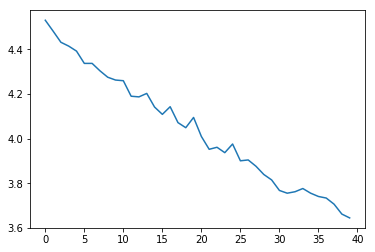

In [47]:
plt.plot(mod1.history['val_loss'])

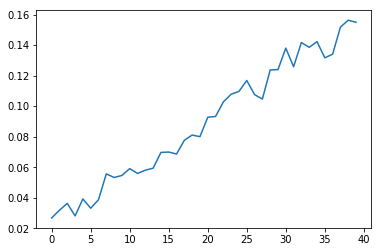

In [48]:
plt.plot(mod1.history['val_acc'])

In [49]:
simple_model.save_weights(filepath='.motion_model_weights.h5')

In [50]:
simple_model2=getSimpleMotionModel(LR=1e-1,  input_shape=(224,224,2), n_classes=101)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 222, 222, 32)      608       
_________________________________________________________________
activation_26 (Activation)   (None, 222, 222, 32)      0         
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 109, 109, 32)      9248      
_________________________________________________________________
activation_27 (Activation)   (None, 109, 109, 32)      0         
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 52, 52, 64)        18496     
__________

In [51]:
simple_model2.load_weights(filepath='.motion_model_weights.h5')

In [52]:
mod2 = simple_model2.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    use_multiprocessing=True,
                    workers=2, epochs=10,
                    verbose=1)

Epoch 1/10
297/298 [============================>.] - ETA: 0s - loss: 12.6539 - acc: 0.0142

Process ForkPoolWorker-388:
Process ForkPoolWorker-385:
Process ForkPoolWorker-387:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/process.py", line 9

KeyboardInterrupt: 